## Using computers to perform Bayesian Inferences

### Example: Inferring Behaviour from Text-Message Data

To know if the user's text-messaging habits have changed over time, either gradually or suddenly.

In [1]:
%matplotlib inline
from IPython.core.pylabtools import figsize
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('ggplot')
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.dpi'] = 300

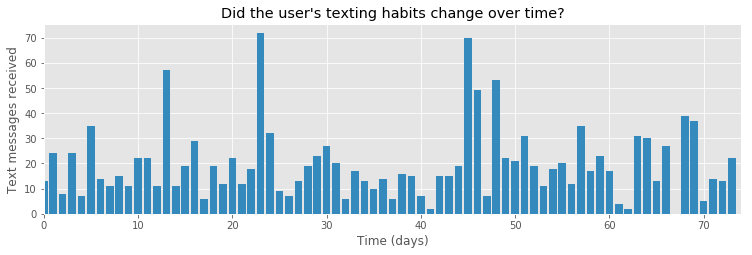

In [2]:
figsize(12.5, 3.5)
count_data = np.loadtxt('txtdata.csv')
n_count_data = len(count_data)
plt.bar(np.arange(n_count_data), count_data,
       color='#348ABD');
plt.xlabel('Time (days)');
plt.ylabel("Text messages received");
plt.title('Did the user\'s texting habits change over time?');
plt.xlim(0, n_count_data);

* Approriate model: Poisson's random variable.
* Text-message count: 
$$C_{i} \sim \text{ Poi}(\lambda)$$

* $\tau$: observation period
* Switchpoint:
$$
\lambda = \begin{cases}\lambda_{1}\text{ if } t \lt \tau\\
\lambda_{2}\text{ if } t \geq \tau
\end{cases}
$$

Interest: inferring the unknown $\lambda$s (choose exponential dist.):
$$\lambda_{1} \sim \text{Exp}(\alpha)$$
$$\lambda_{2} \sim \text{Exp}(\alpha)$$

$\alpha$: hyperparameter (parent variable)

We set:
$$\frac{1}{N} = \sum_{i=0}^{N}C_{i} \sim E[\lambda|\alpha]=\frac{1}{\alpha}$$

Uniform prior belief:
$$\tau \sim \text{DiscreteUniform}(1,70)$$
$$P(\tau = k)=\frac{1}{70}$$

In [3]:
import pymc as pm
# Recall that count data is the variable
# that holds our text counts

alpha = 1.0 / count_data.mean()

lambda_1 = pm.Exponential("lambda_1", alpha)
lambda_2 = pm.Exponential("lambda_2", alpha)

tau = pm.DiscreteUniform("tau", lower=0, upper=n_count_data)

print("Random output: ", tau.random(), tau.random(), tau.random())

('Random output: ', array(21), array(63), array(65))


In [4]:
@pm.deterministic
def lambda_(tau=tau, lambda_1=lambda_1, lambda_2=lambda_2):
    out = np.zeros(n_count_data) # number of data points
    out[:tau] = lambda_1 # lambda before tau is lambda_1
    out[tau:] = lambda_2 # lambda after (and including) tau is lambda_2
    
    return out

In [5]:
observation = pm.Poisson("obs", lambda_, value=count_data,
                        observed=True)
model = pm.Model([observation, lambda_1, lambda_2, tau])

In [6]:
# Mysterious code to be explained in Ch3
# Suffice it to say we'll get 
# 30,000 (40,000 minus 10,000) samples back

mcmc = pm.MCMC(model) 
mcmc.sample(40000, 10000)

c:\users\user\anaconda3\envs\pymc\lib\site-packages\pymc\MCMC.py:81: UserWarning: Instantiating a Model object directly is deprecated. We recommend passing variables directly to the Model subclass.
  warnings.warn(message)


 [-----------------100%-----------------] 40000 of 40000 complete in 7.0 sec

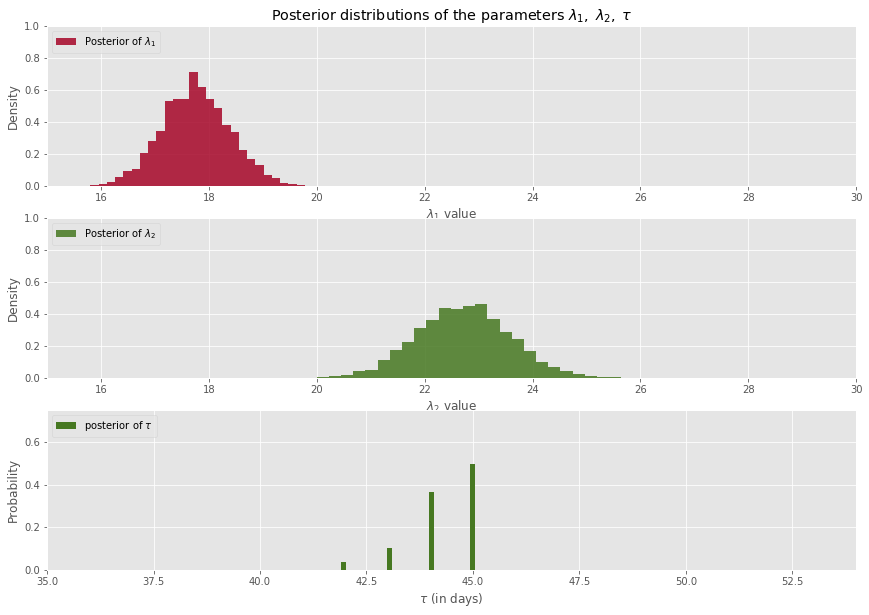

In [7]:
lambda_1_samples = mcmc.trace('lambda_1')[:]
lambda_2_samples = mcmc.trace('lambda_2')[:]
tau_samples = mcmc.trace('tau')[:]

figsize(14.5, 10)
# histogram of the samples

ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=.85, 
        label='Posterior of $\lambda_1$', color='#A60628', normed=True);
plt.legend(loc = "upper left");
plt.title(r"""Posterior distributions of the parameters\
 $\lambda_1, \;\lambda_2, \; \tau$""");
plt.xlim([15, 30]);
plt.xlabel('$\lambda_1$ value');
plt.ylabel('Density');

ax = plt.subplot(312);
ax.set_autoscaley_on(False);
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=.85,
        label='Posterior of $\lambda_2$', color='#467821', normed=True,
        rwidth=.2);
plt.legend(loc='upper left');
plt.xlim([15, 30]);
plt.xlabel('$\lambda_2$ value');
plt.ylabel('Density');

plt.subplot(313);
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(tau_samples, bins=n_count_data, alpha=1, weights=w,
        label=r'posterior of $\tau$', color="#467821");
plt.legend(loc='upper left');
plt.ylim([0, .75]);
plt.xlim([35, len(count_data) - 20]);
plt.xlabel(r"$\tau$ (in days)");
plt.ylabel('Probability');

### Interpretation

* Bayesian returns $\rightarrow$ distribution.
* Posterior dists of unknown: $\lambda_s$, $\tau$.
* The larger the dist, the less certain our posterior is.
* $\lambda_1$ around 18, $\lambda_2$ around 23.
* $\lambda_s$ clearly distinct, indicates there was a change in the user's text-message behaviour.
* $\tau$, near day 45 there was a 50% chance that the user's behaviour change.

# What are the good posterior?

* What is the expected number of texts at day $t$, $0\leq t \leq70$?
* What is expected value of $\lambda$ at time $t$?


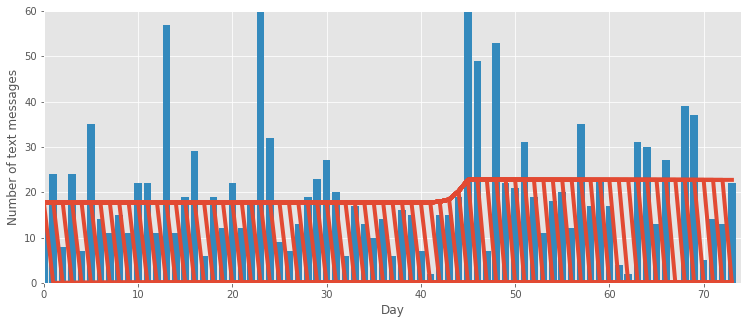

In [8]:
figsize(12.5, 5)
# tau_samples, lambda_1_samples, lambda_2_samples contain
# N samples from the corresponding posterior distribution
N = tau_samples.shape[0]
expected_texts_per_day = np.zeros(n_count_data) # number of data points

for day in range(0, n_count_data):
    # ix is a bool index of all tau samples corresponding to
    # the switchpoint occuring prior to value of "day."
    ix = day < tau_samples
    # Each posterior sample corresponds to a value for tau
    # For each day, that value of tau indicates whether we're 
    # "before" (in the lambda_1, "regime") or
    # "after" (in the lambda_2, "regime") the switchpoint.
    # By taking the posterior sample of lambda_1 and lambda_2 accrodingly,
    # we can average over all samples to get an expected value for lambda on that day.
    # As explained, the "message count" random variable is 
    # Poisson-distributed and therefore lambda (the Poisson parameter) is the expected
    # value of "massage count."
    expected_texts_per_day[day] = (lambda_1_samples[ix].sum() +\
                                   lambda_2_samples[~ix].sum()) / N
    
    plt.plot(range(n_count_data), expected_texts_per_day, lw=4,
            color="#E24A33", label="Expected number of text messages received");
    plt.xlim(0, n_count_data);
    plt.xlabel('Day');
    plt.ylabel('Number of text messages');
    plt.ylim(0, 60);
    plt.bar(np.arange(len(count_data)), count_data, color="#348ABD", 
                      alpha=0.65, label='Observed text messages per day');

In [9]:
    print(expected_texts_per_day)

[17.75785758 17.75785758 17.75785758 17.75785758 17.75785758 17.75785758
 17.75785758 17.75785758 17.75785758 17.75785758 17.75785758 17.75785758
 17.75785758 17.75785758 17.75785758 17.75785758 17.75785758 17.75785758
 17.75785758 17.75785758 17.75785758 17.75785758 17.75785758 17.75785758
 17.75785758 17.75785758 17.75785758 17.75785758 17.75785758 17.75785758
 17.75785758 17.75785758 17.75785758 17.75785758 17.75785758 17.75785758
 17.75785758 17.75785758 17.75796301 17.75796301 17.75814388 17.76071777
 17.90948638 18.39906223 20.21531154 22.72238329 22.72252112 22.7225896
 22.7225896  22.7225896  22.7225896  22.7225896  22.7225896  22.7225896
 22.7225896  22.7225896  22.7225896  22.7225896  22.7225896  22.7225896
 22.7225896  22.7225896  22.7225896  22.7225896  22.7225896  22.7225896
 22.7225896  22.7225896  22.7225896  22.7225896  22.7225896  22.7225896
 22.7225896  22.7225896 ]


The figure illustrates the influence of the switchpoint. We should view this cautious, though; from this view, there is no uncertainty in the red line. Our analysis shows strong support for believing the user's behaviour did change, and that the change was sudden rather than gradual (as demonstrated by $\tau$'s strongly peaked posterior dist.). We can speculate what might have caused this: a cheaper text-message rate, a recent weather-to-text subscription, or perhaps a new relationship. 

## Determining statistically if the 2 $\lambda$s are indeed different

* Inspected visually posteriors of $\lambda_1$ and $\lambda_2$ to declare them different. This was fair as the general locations of the posteriors were very apart.
* What if this were not true?? What if the distributions partially overlapped? How can we make decision more formal??

$$P(\lambda_{1} < \lambda_{2}|\text{data})$$

* 50% : no better than flipping coin,
* 100%: very confident

In [10]:
print(lambda_1_samples < lambda_2_samples)

[ True  True  True ...  True  True  True]


In [11]:
# How often this is happen?
print(lambda_1_samples < lambda_2_samples).sum()

30000


In [12]:
# How many samples are there?
print(lambda_1_samples.shape[0])

30000


In [13]:
# The ratio is the probability. Or, we can just use .mean():
print((lambda_1_samples < lambda_2_samples).mean())

1.0


What is the probability that the values differ by at least 1? 2? 5? 10?

In [14]:
# the vector abs(lambda_1_samples - lambda_2_samples) > 1 is a boolean,
# True if the values are more than 1 apart, False otherwise.
# How often does this happen? Use.mean()
for d in [1,2,5,10]:
    v = (abs(lambda_1_samples - lambda_2_samples) >= d).mean()
    print("What is the probability the difference is larger than %d? %.2f"%(d,v))

What is the probability the difference is larger than 1? 1.00
What is the probability the difference is larger than 2? 1.00
What is the probability the difference is larger than 5? 0.49
What is the probability the difference is larger than 10? 0.00


In [15]:
print(lambda_1_samples.mean())
print(lambda_2_samples.mean())

17.757857576426993
22.722589597140452


Expected percentage increase in text-message rates:
Given two numbers, $a$ & $b$, the relative increase is given by:
$$\frac{(a - b)}{b}$$

In our samples, we don't know with certainty what $\lambda_1$ & $\lambda_2$ are. We compute posterior of the relative increase:

relative_increase_samples = (lambda_2_samples - lambda_1_samples) / lambda_1_samples
print(relative_increase_samples)

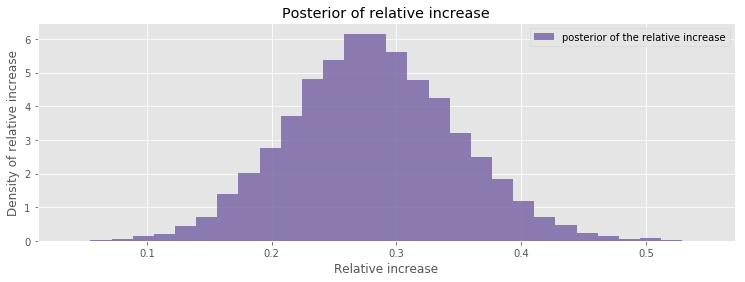

In [18]:
figsize(12.5, 4)
plt.hist(relative_increase_samples, histtype='stepfilled',
        bins=30, alpha=.85, color='#7A68A6', normed=True,
        label='posterior of the relative increase');
plt.xlabel('Relative increase');
plt.ylabel('Density of relative increase');
plt.title('Posterior of relative increase');
plt.legend();

mean value:

In [19]:
print(relative_increase_samples.mean())

0.2812136559817556


Mean of $\lambda_1$ given $\tau < 45$

In [20]:
ix = tau_samples < 45
print(lambda_1_samples[ix].mean())

17.754260805963
